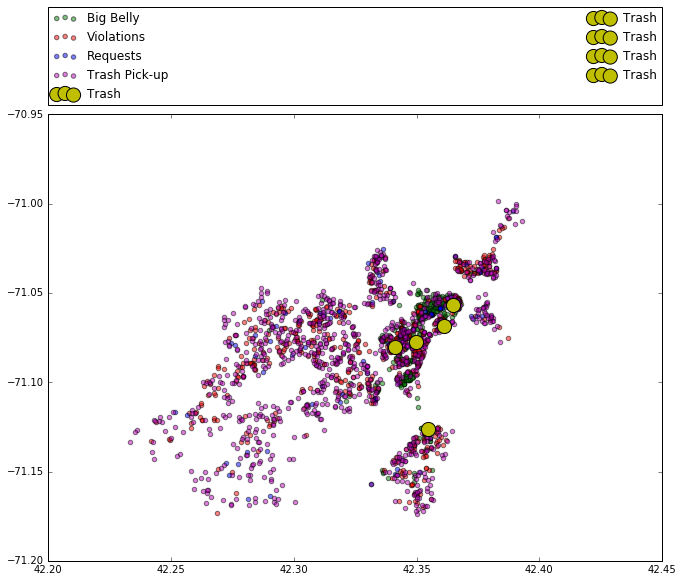

0

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from scipy.spatial import cKDTree
import math
import numpy
import urllib.request
import json
import dml
import prov.model
import datetime
import uuid

# to be used in the scatter plot
COLORMAP = {'Big Belly': 'g', 'Violations': 'r', 'Requests': 'b', 'Trash Pick-up': 'm'}

def project(R, p, dataType):
    return [p(t, dataType) for t in R]

def difference(R, S):
    return [t for t in R if t not in S]

def removeCoordinates(R, S):
    filtered_list = []
    match_found = False
    for r in R:
        for s in S:
            if (r[0], r[1]) == (s[0],s[1]):
                match_found = True
                break
        if not match_found: filtered_list.append(r)
        match_found = False
    return filtered_list
                

#returns weights based on average big belly fullness
def bbWeights(t):
    perc = t['percentage']
    if perc >= 0.9 and perc <= 1.0:
        return (0.3 * perc)
    elif perc >= 0.7 and perc < 0.9:
        return (0.25 * perc)
    elif perc >= 0.5 and perc < 0.7:
        return (0.2 * perc)
    elif perc >= 0.3 and perc < 0.5:
        return (0.15 * perc)
    elif perc >= 0.0 and perc < 0.3:
        return (0.1 * perc)
    else:
        raise ValueError

#returns weights based on severity of sanitary violation
def violWeights(t):
    v = t['type']
    count = t['count']
    if v == 'improper storage trash':
        return (0.75 * count)
    elif v == 'illegal dumping':
        return (0.75 * count)
    elif v == 'overfilling of barrel/dumpster':
        return (1.0 * count)
    elif v == 'storage of garbage & rubbish':
        return (0.75 * count)
    #NOTE: labels are double-sapced for Insects Rodents Animals
    elif v == 'Insects  Rodents  Animals': 
        return (0.3 * count)
    elif v == 'trash illegally dump container':
        return (0.75 * count)
    else:
        raise ValueError

#returns weights based on severity of service request      
def reqWeights(t):
    v = t['type'].lower()
    count = t['count']
    if v == 'illegal dumping':
        return (0.75 * count)
    elif v == 'improper storage of trash (barrels)':
        return (0.75 * count)
    elif v == 'mice infestation - residential':
        return (0.3 * count)
    elif v == 'missed trash/recycling/yard waste/bulk item':
        return (0.5 * count)
    elif v == 'overflowing or un-kept dumpster':
        return (1.0 * count)
    elif v == 'pest infestation - residential':
        return (0.3 * count)
    elif v == 'rodent activity':
        return (0.5 * count)
    elif v == 'unsanitary conditions - establishment':
        return (0.3 * count)
    else:
        raise ValueError

#returns negative weights based on the total times trash collected
def scheduleWeights(t):
    return -1 * t['count']

# used to format the data to prepare to graph
def process(R, dataType):
    color = COLORMAP[dataType]
    X = []
    Y = []
    W = []
    for t in R:
        lat = float(t['location'][0])
        lon = float(t['location'][1])
        #weight = int(t['count'])
        X.append(lat)
        Y.append(lon)
        #call helper function and append corresponding weight
        if dataType == "Big Belly":
            scaledW = bbWeights(t)
        elif dataType == 'Violations':
            scaledW = violWeights(t)
        elif dataType == 'Requests':
            scaledW = reqWeights(t)
        elif dataType == 'Trash Pick-up':
            scaledW = scheduleWeights(t)
        else:
            raise ValueError 
        W.append(20 * scaledW)
    plt.scatter(X, Y, c=color, alpha=0.5, label=dataType)
    return list(zip(X,Y)),list(zip(X,Y,W))

def findOptimalLocation(coordinates, weight_list, num_trash, radius = 0.0013, iterations = 15000):
    
    # keep track of visited coordinates
    visited = []
    
    # final lists to return
    trashLocations = []
    location_weights = []
    
    # start the for loop here
    for i in range(num_trash):
        
        #make min weight
        max_weight = -float('Inf')
        trash_loc = (0,0)
        neighbors = []

        #make the kd tree
        tree = cKDTree(coordinates)

        # start the for loop
        for i in range(iterations):
            # pick a coordinate
            random_index = random.randint(0,len(coordinates)-1)
            random_coor = coordinates[random_index]
    #         print(random_coor)

            within_radius = []

            distances, indices = tree.query(random_coor, len(coordinates)-1, p=2, distance_upper_bound=radius)
            for dist, ind in zip(distances, indices):
                # had to typecast inf for float to test to inf
                if dist == float('Inf'):
                    break
                within_radius.append(weight_list[ind])

            # if weight is greater than curr max assign new max and new coor
            total_weight = sum([r[2] for r in within_radius])
            if total_weight > max_weight:
                max_weight = total_weight
                trash_loc = random_coor
                neighbors = within_radius
    
        # save the found optimization
        trashLocations.append(trash_loc)
        location_weights.append(200 + (math.pi * radius**2))
        
        # reset the list to remove already included points        
        coordinates = removeCoordinates(coordinates, neighbors)
        weight_list = difference(weight_list, neighbors)
        
#         print(len(weight_list))    
#         print(len(coordinates))
        
    return trashLocations, location_weights
    
    

class optimization(dml.Algorithm):
    contributor = 'andradej_chojoe'
    reads = ['andradej_chojoe.trashSch_transf', \
             'andradej_chojoe.bigbelly_transf', \
             'andrade_chojoe.codeViolations', \
             'andradej_chojoe.hotline_transf']
    writes = ['andradej_chojoe.optimization_results']
    
    
    @staticmethod
    def execute(trial = False):
        startTime = datetime.datetime.now()

        #Set up database connection
        client = dml.pymongo.MongoClient()
        repo = client.repo
        repo.authenticate('andradej_chojoe', 'andradej_chojoe')
        
        repo.dropPermanent('andradej_chojoe.optimization_results')
        repo.createPermanent('andradej_chojoe.optimization_results')
        
        # gather all the datasets
        trashSchData = repo['andradej_chojoe.trashSch_transf'].find()
        bigBellyData = repo['andradej_chojoe.bigbelly_transf'].find()
        codeViolData = repo['andradej_chojoe.codeViol_transf'].find()
        hotlineData = repo['andradej_chojoe.hotline_transf'].find()
        
        # define the figure
        fig = plt.figure(figsize=(11,8))
        
        coorBB, bigBellyData = process(bigBellyData, 'Big Belly')
        coorCV, codeViolData = process(codeViolData, 'Violations')
        coorRQ, hotlineData = process(hotlineData, 'Requests')
        coorTS, trashSchData = process(trashSchData, 'Trash Pick-up')
        
        # merge all data for master coordinate list (ADD THIS)
        masterCoordinateList = coorBB + coorCV + coorRQ + coorTS
        masterCoorWeightList = bigBellyData + codeViolData + hotlineData + trashSchData
#         print(len(masterCoordinateList))
        
        # call the optimization function
        loc, weight = findOptimalLocation(masterCoordinateList, masterCoorWeightList, 5)
        
        #insert into mongo db
        for i in range(len(loc)):
            entry = {'location': loc[i], 'weight': weight[i]}
            repo['andradej_chojoe.optimization_results'].insert_one(entry)
            
        
        for coor in loc:
            plt.scatter(coor[0],coor[1],s=weight[0], c='y', alpha=1, label="Trash")
        
        # show the graph and make it look nice
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
        plt.show()
        
        return 0
    
    @staticmethod
    def provenance(doc = prov.model.ProvDocument(), startTime = None, endTime = None):
        return 0
    
optimization.execute()
# doc = codeViolations.provenance()
# print(doc.get_provn())
# print(json.dumps(json.loads(doc.serialize()), indent=4))